In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

GPU_PRESENT = False #Set to True if you have GPU on your machine

# DeepDream

DeepDream is an algorithm that uses CNNs to generate psychedelic-looking images. It allows us to visualize what features a particular layer of pretrained CNNs have learned. 

![img](./features.png)

First, a base image is fed to the pretrained CNN and forward pass is done until a particular layer. In order to visualize what that particular layer has learned, we need to maximize the activations through that layer. The gradients of that layer are set equal to the activations from that layer, and then gradient ascent is done on the input image (gradient ascent is similar to gradient descent except that instead of minimizing the cost, we are trying to maximize the cost). This maximizes the activations of that layer.

However, doing just this much does not produce good images. Various techniques are used to make the resulting image better. Gaussian blurring can be done to make the image smoother.

One main concept in making images better is the use of octaves. Input image is repeatedly downscaled, and gradient ascent is applied to all the images, and then the result is merged into a single output image.

To learn more, read this [blog post](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) from Google.

![img](./explanation.png)

Here are some helper functions that help you preprocess the image. You do not need to read these.

In [3]:
def load_image(path):
    image = Image.open(path)
    plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.title("Base Image")
    return image

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

def deprocess(image):
    if GPU_PRESENT:
        return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    return image * torch.Tensor([0.229, 0.224, 0.225])  + torch.Tensor([0.485, 0.456, 0.406])

We will be using a pretrained CNN called VGG16. You are free to explore other CNNs too.

In [4]:
vgg = models.vgg16(pretrained=True) #TODO
if GPU_PRESENT:
    vgg = vgg.cuda()
print(vgg)
modulelist = list(vgg.features.modules())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Main functions

### dreamify
This is the actual deep_dream code. It takes an input image, makes a forward pass till a particular layer, and then updates the input image by gradient ascent.

### deep_dream_vgg 
This is a recursive function. It repeatedly downscales the image, then calls dreamify. Then it upscales the result, and merges (blends) it to the image at one level higher on the recursive tree. The final image is the same size as the input image.

In [5]:
def dreamify(image, layer, iterations, lr):
    if GPU_PRESENT:
        input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
    else:
        input = Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    vgg.zero_grad()
    for i in range(iterations):

        out = input
        for j in range(layer):
            out = modulelist[j+1](out)
        loss = out.norm() #TODO: normalize out
        loss.backward() #TODO: BackPropagation 
        input.data = input.data + lr * input.grad.data
    
    input = input.data.squeeze()
    input.transpose_(0,1)
    input.transpose_(1,2)
    input = np.clip(deprocess(input), 0, 1) #TODO: Deprocess the image and make sure it is within the range of 0 and 1. Hint: use deprocess() and np.clip()
    im = Image.fromarray(np.uint8(input*255))
    return im

In [6]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    
    if num_octaves > 0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
            
        image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves - 1) #TODO: recursively call itself with num_octaves - 1
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size,Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)

    img_result = dreamify(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    return img_result

Load a base image. Feel free to load your own image.

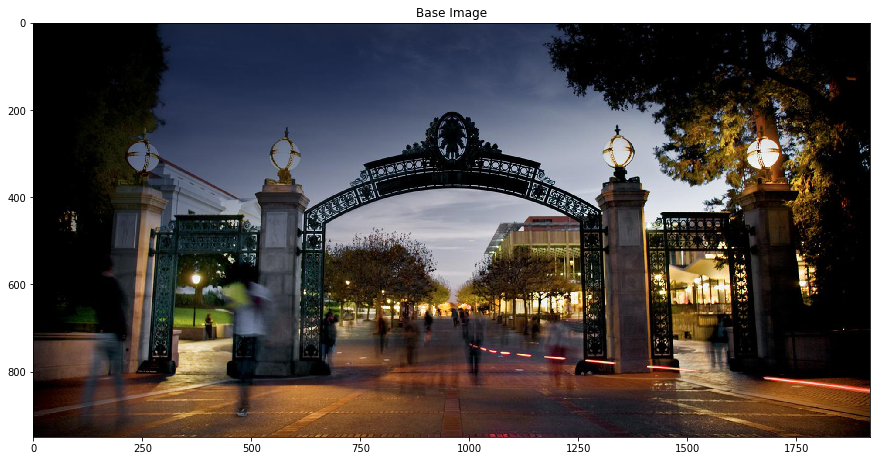

In [7]:
sky = load_image('sather.png')

Notice that the shallow layers learn basic shapes, lines, edges. After that, layers learn patterns. And the deeper layers learn much more complex features like eyes, face, etc.

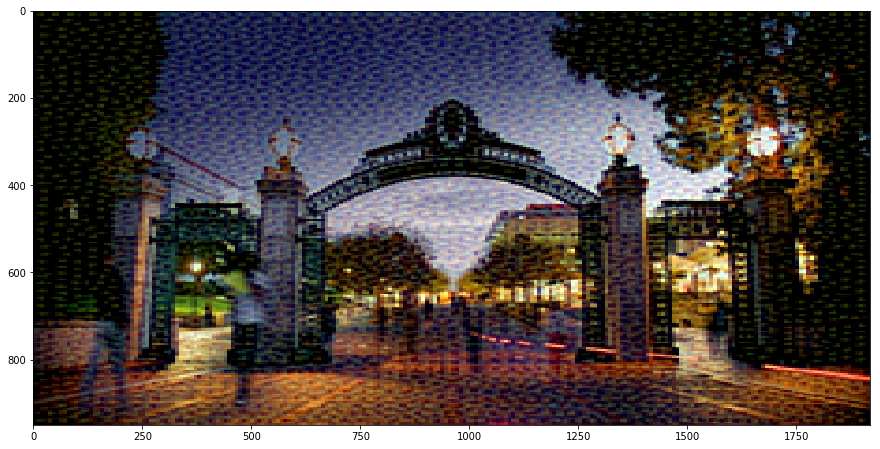

In [8]:
sky_5 = deep_dream_vgg(sky, 5, 5, 0.3, 2, 20)
plt.figure(figsize=(15, 15))
plt.imshow(sky_5)

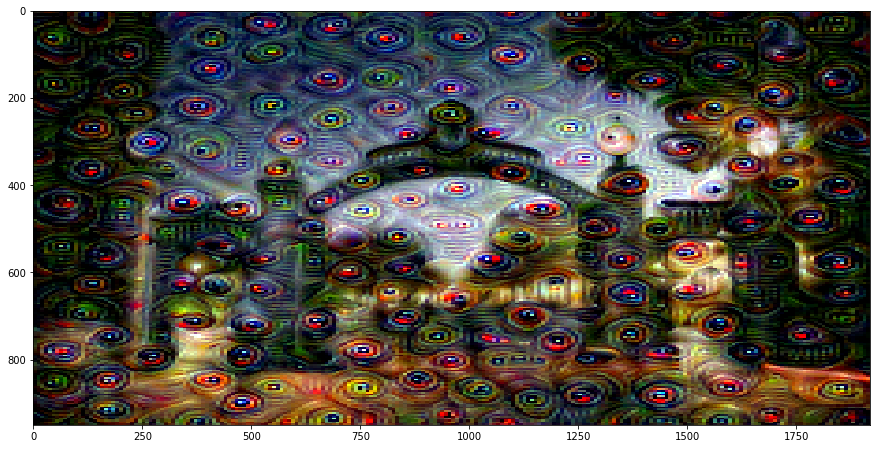

In [11]:
sky_17 = deep_dream_vgg(sky, 17, 3, 0.3, 2, 20)
plt.figure(figsize=(15, 15))
plt.imshow(sky_17)

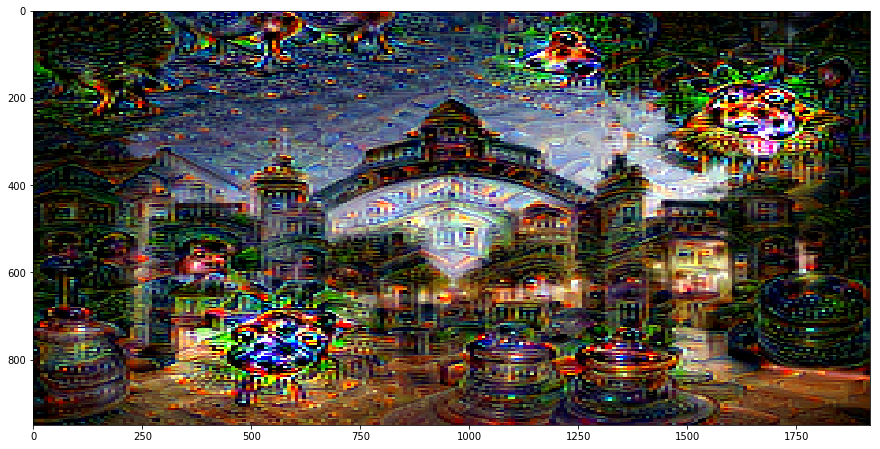

In [12]:
sky_26 = deep_dream_vgg(sky, 26, 5, 0.2, 2, 20)
plt.figure(figsize=(15, 15))
plt.imshow(sky_26)